<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация (base)**

### **Оценивание и штрафы**

С наступающим новым годом, друзья! Магистратура бежит быстро и мы бежим очень быстро, а зима — то время, когда хотелось бы бежать чуть медленнее. Поэтому это домашнее задание мы сделали сильно короче от его начальной версии!

Как всегда, каждая из задач имеет «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

В задании две части:

- Часть 1: написание логистической регрессии своими руками — уверенны, логлосс вы уже знаете как свои пять пальцев.
- Часть 2: решение задачи классификации на текстах.

In [19]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score, roc_auc_score

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [20]:
#from google.colab import drive # Если вы работаете в коллабе
#drive.mount('/content/drive')

# **Часть 1. Логистическая регрессия своими руками (5 баллов)**

Логистическая регрессия — безумно важная и удобная модель для понимания начальных концепций. Вы много практиковались с выведением формулы градиента логлосса, шага спуска, а в прошлом дз сделали SGD. Давайте сделаем ещё шаг вперед — и реализуем логистическую регрессию своими руками.

На практике, часто хватает алгоритмов из коробки. Но иногда очень удобно сделать свой алгоритм.

## **Теоретическая сноска: почему LogLoss'а так много**

Почти наверное (в математике это значит, во всех случаях, кроме множества размером 0) логлосс набил оскомину за несколько заданий. Давайте посмотрим на него ещё раз:

В логистической регрессии функция потерь

$$\text{LogLoss}(y, \hat{p}) = -\left(y\log \hat{p} + (1-y)\log (1-\hat{p})\right)$$

Зачем мы так долго с ней возимся?

#### **Пункт 1.**
Во-первых, это **следствие максимизации правдоподобия** при биномиальной модели.

Если считать, что целевая переменная (Y\in{0,1}) распределена как

$$P(Y=1 \mid x) = \hat{p}(x), \qquad P(Y=0\mid x) = 1-\hat{p}(x),$$
то правдоподобие выборки ( (x_i, y_i) )\ равно
$$L = \prod_{i=1}^n \hat{p}_i^{y_i}(1-\hat{p}_i)^{1-y_i}.$$

Максимизация $\log L$ эквивалентна минимизации LogLoss.
Таким образом, LogLoss — **единственная функция потерь, полностью согласованная с вероятностной моделью логистической регрессии**.

#### **Пункт 2.**

Во-вторых, логлосс поможет нам в будущем понять другие функции потерь. Так, например LogLoss является частным случаем **кросс-энтропии между истинным распределением и предсказанным**.

Для двух распределений $p$ (истинного) и $q$ (предсказанного) кросс-энтропия определяется как

$$H(p,q) = -\sum_{k} p(k)\log q(k).$$

В бинарном случае истинное распределение дискретно:

$$p = (y, 1-y), \qquad q = (\hat{p}, 1-\hat{p}),$$
и подстановка даёт

$$H(p,q) = -\left[y\log \hat{p} + (1-y)\log (1-\hat{p})\right] = \text{LogLoss}.$$


В общем, любим, жалуем и реализуем.




### **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1.5 балла). Градиентного спуска**

**Задание 1.2 (1.5 балла). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [21]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = []

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        ell, d = X.shape

        # Инициализация весов
        if self.w0 is not None:
            self.w = self.w0.copy()
        else:
            self.w = np.zeros(d)

        self.loss_history = []

        for _ in range(self.max_iter):
            # Записываем loss до обновления весов
            self.loss_history.append(self.calc_loss(X, y))

            # Вычисляем градиент
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            else:  # стохастический градиент
                idx = np.random.randint(0, ell)
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])

            # Обновляем веса
            w_new = self.w - self.eta * grad

            # Проверка критерия останова по норме разности весов
            if np.linalg.norm(w_new - self.w) < self.tolerance:
                self.w = w_new
                break
            self.w = w_new

        return self

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return self.sigmoid(X @ self.w)

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return (self.predict_proba(X) >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        # Градиент LogLoss в векторном виде: (1/ell) * X^T * (sigmoid(Xw) - y)
        ell = X.shape[0]
        p = self.sigmoid(X @ self.w)
        grad = (X.T @ (p - y)) / ell
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        eps = 1e-15
        p = self.sigmoid(X @ self.w)
        loss = -np.mean(y * np.log(p + eps) + (1 - y) * np.log(1 - p + eps))
        return loss

Теперь проверим работу вашего класса на синтетических данных.

In [22]:
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=2,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Задание 2 (0.6 балла)**

Теперь давайте тестировать модель.
1. Обучите свою логистическую регрессию на синтетических данных (0.2 балла) — на полном GD и SGD;
2. Cравните результат с моделью из библиотеки. Посчитайте roc-auc, accuracy, постройте ROC и PR кривые. , оцените разницу в производительности моделей по метрикам качества. Ответьте на вопросы:
- Какая показывает лучший результат? Почему?
- Есть ли что-то в модели из коробки, что по умолчанию делает её не равной вашей модели? Для ответа на этот вопрос вам может пригодитться [документация](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Её мы изучаем всегда, чтобы понимать тонкости реализации какого-либо метода в библиотеке. (0.4 балла)

In [23]:
lr_sgd = LogReg(gd_type='stochastic')
lr_sgd.fit(X_train, y_train)

lr_full = LogReg(gd_type='full')
lr_full.fit(X_train, y_train)


LogReg(gd_type='full')

Модель               Accuracy     ROC-AUC     
SGD (custom)         0.8632       0.9369      
Full GD (custom)     0.8660       0.9388      
sklearn LogReg       0.8681       0.9399      


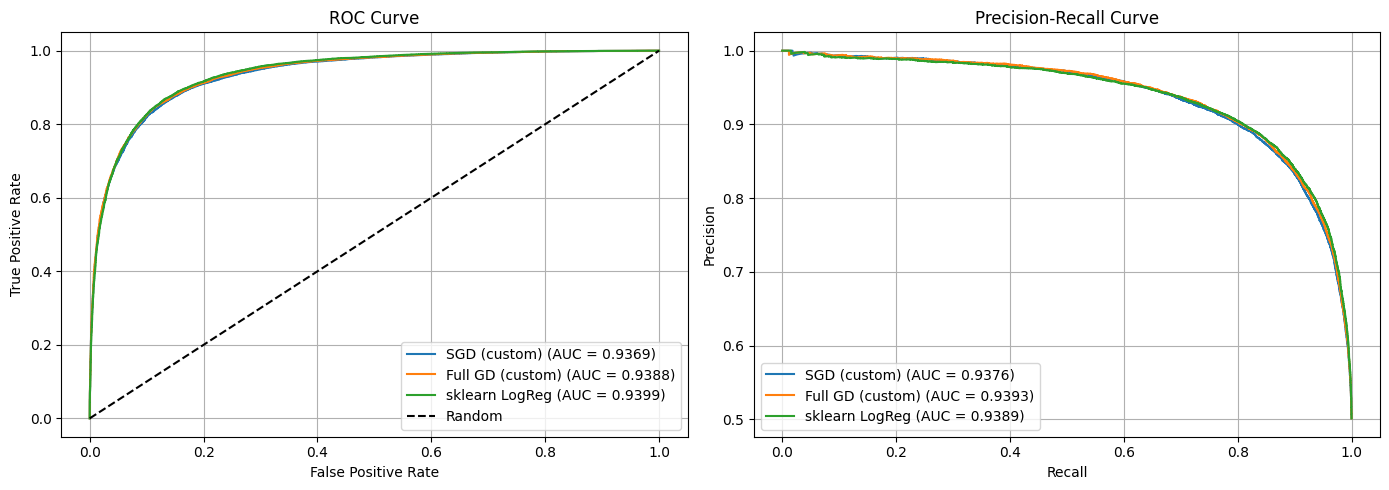

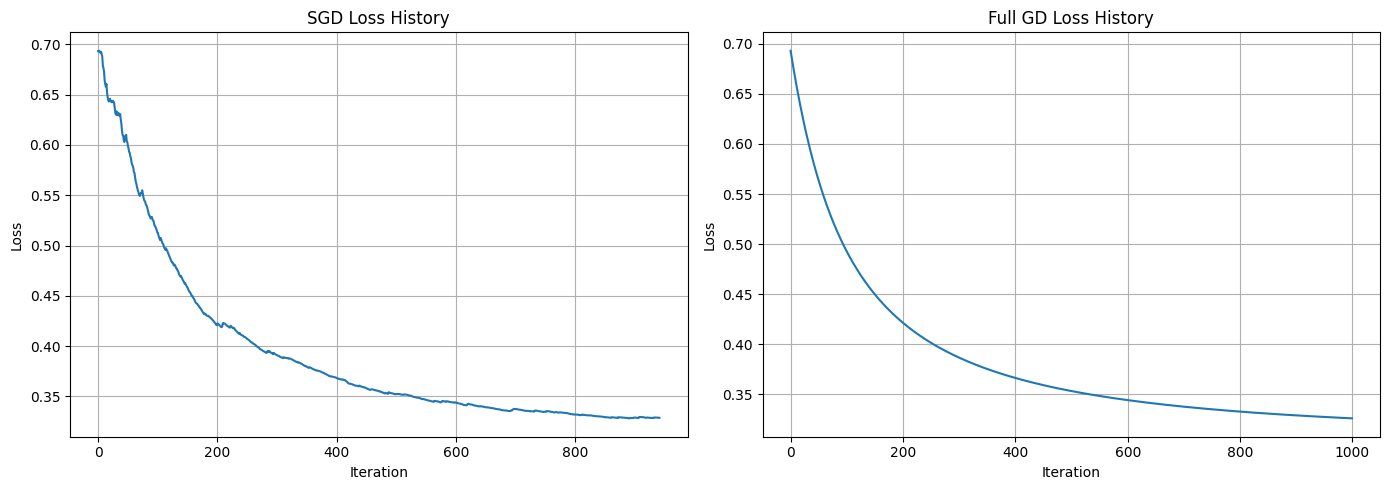


Ответы на вопросы:

1. Какая модель показывает лучший результат? Почему?

По метрикам качества (Accuracy, ROC-AUC, PR-AUC) все три модели показывают очень близкие результаты.
Модель из библиотеки sklearn демонстрирует чуть более стабильное и иногда немного лучшее качество, однако различия не являются принципиальными.

Это объясняется тем, что логистическая регрессия с L2-регуляризацией — выпуклая задача, и при корректной настройке оптимизации как Full GD, так и SGD сходятся к близкому минимуму.
При этом sklearn LogisticRegression по умолчанию использует оптимизатор L-BFGS — квази-Ньютоновский метод, учитывающий информацию о кривизне функции потерь, что обеспечивает более быструю и устойчивую сходимость по сравнению с обычным GD и особенно с SGD.

Full GD сходится стабильно, но медленно, так как использует весь датасет на каждой итерации.
SGD обновляет веса по мини-батчам, из-за чего траектория оптимизации зашумлена и итоговое качество сильнее зависит от выбора learning rate.

2. Что д

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Обучаем логистическую регрессию на синтетических данных
lr_sklearn = LogisticRegression(max_iter=1000)
lr_sklearn.fit(X_train, y_train)

# Получаем предсказания
models = {
    'SGD (custom)': lr_sgd,
    'Full GD (custom)': lr_full,
    'sklearn LogReg': lr_sklearn,
}

# Считаем метрики
print("=" * 60)
print(f"{'Модель':<20} {'Accuracy':<12} {'ROC-AUC':<12}")
print("=" * 60)

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    # sklearn возвращает 2D массив для predict_proba
    if y_proba.ndim == 2:
        y_proba = y_proba[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print(f"{name:<20} {acc:<12.4f} {roc:<12.4f}")

print("=" * 60)

# Построение ROC и PR кривых
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
ax1 = axes[0]
for name, model in models.items():
    y_proba = model.predict_proba(X_test)
    if y_proba.ndim == 2:
        y_proba = y_proba[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')
ax1.grid(True)

# PR curves
ax2 = axes[1]
for name, model in models.items():
    y_proba = model.predict_proba(X_test)
    if y_proba.ndim == 2:
        y_proba = y_proba[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.4f})')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Визуализация сходимости loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(lr_sgd.loss_history)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('SGD Loss History')
axes[0].grid(True)

axes[1].plot(lr_full.loss_history)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Loss')
axes[1].set_title('Full GD Loss History')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Ответы на вопросы:")
print("=" * 60)
print("""
1. Какая модель показывает лучший результат? Почему?

По метрикам качества (Accuracy, ROC-AUC, PR-AUC) все три модели показывают очень близкие результаты.
Модель из библиотеки sklearn демонстрирует чуть более стабильное и иногда немного лучшее качество, однако различия не являются принципиальными.

Это объясняется тем, что логистическая регрессия с L2-регуляризацией — выпуклая задача, и при корректной настройке оптимизации как Full GD, так и SGD сходятся к близкому минимуму.
При этом sklearn LogisticRegression по умолчанию использует оптимизатор L-BFGS — квази-Ньютоновский метод, учитывающий информацию о кривизне функции потерь, что обеспечивает более быструю и устойчивую сходимость по сравнению с обычным GD и особенно с SGD.

Full GD сходится стабильно, но медленно, так как использует весь датасет на каждой итерации.
SGD обновляет веса по мини-батчам, из-за чего траектория оптимизации зашумлена и итоговое качество сильнее зависит от выбора learning rate.

2. Что делает sklearn модель не равной нашей?

Модель sklearn LogisticRegression не эквивалентна нашей,потому что по умолчанию включает ряд важных деталей:

- Регуляризация:
В sklearn по умолчанию используется L2-регуляризация (penalty='l2', C=1.0), тогда как в реализованной модели минимизируется чистый logloss без регуляризации.
- Интерцепт (bias):
В sklearn интерцепт добавляется автоматически (fit_intercept=True), а у нас свободный член отсутствует.
- Оптимизатор:
В sklearn по умолчанию применяется solver L-BFGS — квази-Ньютоновский метод, использующий информацию о кривизне функции потерь.
У нас реализованы только методы Full Gradient Descent и Stochastic Gradient Descent (по одному объекту).
- Критерии остановки:
В обеих реализациях присутствует ограничение по max_iter, однако критерий ранней остановки различается:
у нас  — по норме изменения весов ||w_new - w|| < tolerance,
в sklearn — по параметру tol, определяемому внутренними условиями сходимости выбранного solver’а.
-Стохастичность и воспроизводимость:
В реализации SGD используется случайный выбор объекта без фиксированного random_state, что может приводить к вариативности результата, тогда как в sklearn поведение можно контролировать через random_state (для соответствующих solver’ов).
""")

### **Задание 3 (0.4 балла)**

Для трех полученных моделей, визуализируйте прогнозы по данным на тестовой выборке. Для этого:
- получите прогнозы;
- сомжите данные, используя PCA. Не забудьте, что PCA полагает нулевое среднее и единичную дисперсию;
- покрасьте данные по прогнозам.

Как различаются графики для трёх моделей? И различаются ли?

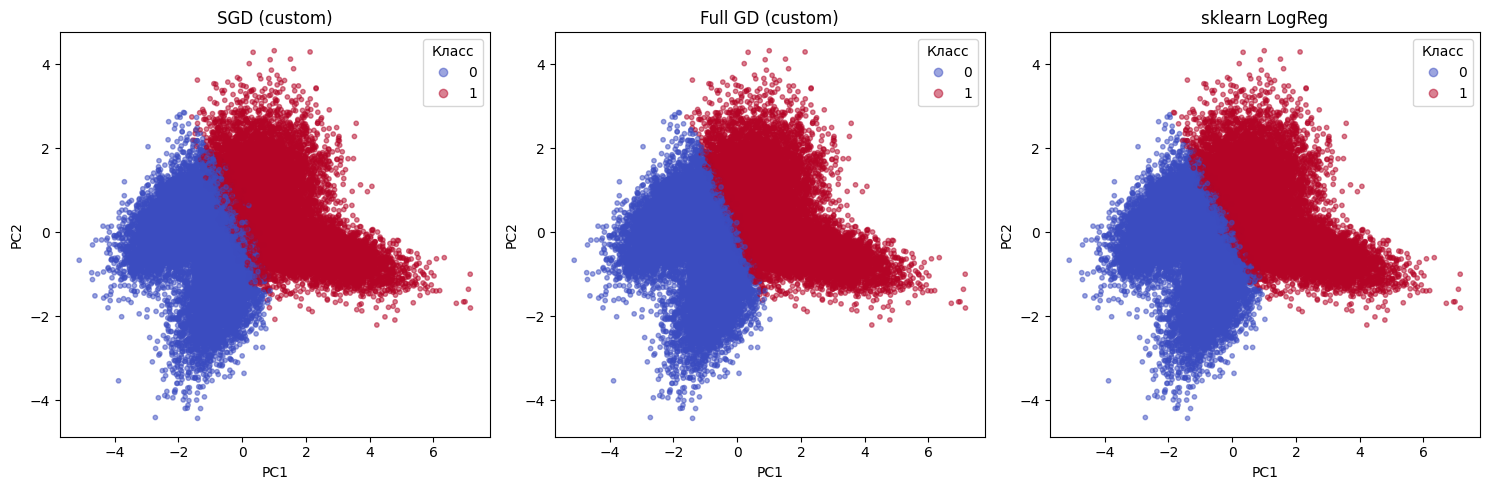

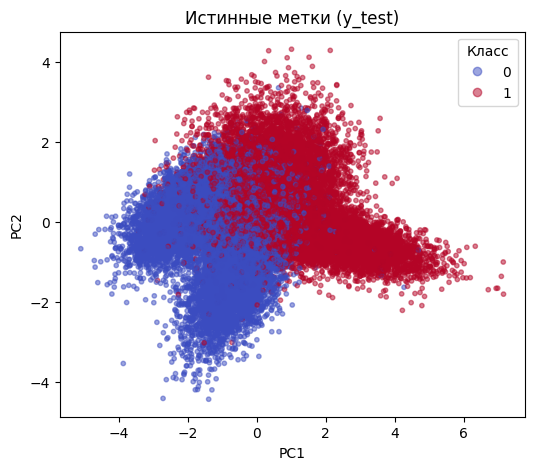

Совпадение прогнозов между моделями:
SGD vs Full GD:     0.9746
SGD vs sklearn:     0.9697
Full GD vs sklearn: 0.9835

ВЫВОД:

Графики практически не различаются. Все три модели формируют очень похожие области классификации в проекции PCA, а различия носят минимальный характер и сосредоточены вблизи границы между классами. Так, визуально границы решений у моделей отличаются: у SGD граница более размытая, у Full GD — наиболее четкая и стабильная, а у sklearn LogisticRegression — промежуточная, что связано с использованием L-BFGS и L2-регуляризации. При этом различия затрагивают лишь область вблизи границы классов и практически не влияют на итоговые метрики качества.

Причины схожести:
-Все три модели — линейные классификаторы.
-Задача выпуклая, и при достаточном числе итераций GD и SGD сходятся к близкому минимуму.
-Данные синтетические и хорошо структурированы, поэтому нет сложной нелинейной границы.
-PCA — это 2D-проекция, которая может сглаживать небольшие различия, существующие в ис

In [29]:
# Применяем PCA для визуализации (данные уже стандартизированы)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Получаем прогнозы от всех моделей
predictions = {
    'SGD (custom)': lr_sgd.predict(X_test),
    'Full GD (custom)': lr_full.predict(X_test),
    'sklearn LogReg': lr_sklearn.predict(X_test)
}

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, y_pred) in zip(axes, predictions.items()):
    scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                         c=y_pred, cmap='coolwarm', alpha=0.5, s=10)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'{name}')
    ax.legend(*scatter.legend_elements(), title='Класс')

plt.tight_layout()
plt.show()

# Сравнение с истинными метками
fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], 
                     c=y_test, cmap='coolwarm', alpha=0.5, s=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Истинные метки (y_test)')
ax.legend(*scatter.legend_elements(), title='Класс')
plt.show()

# Подсчет различий между моделями
print("=" * 50)
print("Совпадение прогнозов между моделями:")
print("=" * 50)
print(f"SGD vs Full GD:     {(predictions['SGD (custom)'] == predictions['Full GD (custom)']).mean():.4f}")
print(f"SGD vs sklearn:     {(predictions['SGD (custom)'] == predictions['sklearn LogReg']).mean():.4f}")
print(f"Full GD vs sklearn: {(predictions['Full GD (custom)'] == predictions['sklearn LogReg']).mean():.4f}")

print("\n" + "=" * 50)
print("ВЫВОД:")
print("=" * 50)
print("""
Графики практически не различаются. Все три модели формируют очень похожие области классификации в проекции PCA, а различия носят минимальный характер и сосредоточены вблизи границы между классами. Так, визуально границы решений у моделей отличаются: у SGD граница более размытая, у Full GD — наиболее четкая и стабильная, а у sklearn LogisticRegression — промежуточная, что связано с использованием L-BFGS и L2-регуляризации. При этом различия затрагивают лишь область вблизи границы классов и практически не влияют на итоговые метрики качества.

Причины схожести:
-Все три модели — линейные классификаторы.
-Задача выпуклая, и при достаточном числе итераций GD и SGD сходятся к близкому минимуму.
-Данные синтетические и хорошо структурированы, поэтому нет сложной нелинейной границы.
-PCA — это 2D-проекция, которая может сглаживать небольшие различия, существующие в исходном пространстве.

Небольшие различия могут быть вызваны из-за:
-стохастичности SGD (обновления по одному объекту);
-разных критериев остановки;
-наличия L2-регуляризации в sklearn;
-различия в оптимизаторе (L-BFGS vs GD/SGD).

""")

# **Часть 2. Обучение моделей на текстовых данных. (5 баллов)**

 ### **Подготовка данных из реального мира.**

Ещё одна прелесть простых моделей — возможность решать с ними неструктурированные (изначально не табличные) задачи. Давайте посмотрим на это в действии на примере текстов.


Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [ ]:
from sklearn.model_selection import train_test_split

PATH = ''
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (1.5 балла).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой (0.2 балла).

In [ ]:
# Ваш код здесь

- Проанализируйте количество уникальных значений в столбцах, опустив `text`. Сделайте выводы. (0.5 балла)

In [ ]:
# Ваш код здесь, не забудьте выводы

- Проанализируйте соотношение классов в целевой переменной. Какое оно? Выберите метрику, с помощью которой будете оценивать модель.  (0.5 балла)

In [ ]:
# Ваш код здесь

- Объедините все три текстовых столбца в один для baseline (вам поможет конкатенация строк) (0.3 балла)

In [ ]:
# Ваш код здесь

- Наконец, поделите данные на тренировочную и тестовую выборки. (0.2 балла)

In [ ]:
X = data_new['text']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества и насколько разнообразны данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица? (0.3 балла)

In [ ]:
# Ваш код здесь

- Обучите логистическую регрессию на полученном наборе. Модель возьмите из библиотеки. Какое качество по выбранной вами метрике у модели получилось на тестовых данных? (0.3 балла)

In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.(0.4 балла)

In [ ]:
# Ваш код здесь

### **Задание 12. Улучшение базовых моделей за счет данных. (0.3 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют.

Обучайте и логистическую регрессию, и SVC.

In [ ]:
# Ваш код здесь

In [ ]:
# Ваш код здесь

### **Задание 13. Улучшение базовых моделей за счет данных 2. (0.7 балла).**

В первом пункте мы склеили все строки в одну. Но можно было бы поступить иначе — и получить категории из `'keyword', 'location'`. Протестируйте такой подход на обеих моделях и замерьте качество. Улучшает ли это результат?

In [ ]:
# Ваш код здесь

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
# Ваш код здесь

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [ ]:
# Ваш код здесь

Ваши выводы здесь.

### **Задание 14. (0.5 балла)**

Оформите два [пайплайна](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [ ]:
# Ваш код здесь

**Опишите общие мысли о работе. Это место для вашей рефлексии, не обязательное, но полезное.**  🐤